# NYC Parking Tickets: Violation Rate Prediction

In [911]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

from datetime import datetime, timedelta

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# importing libraries

import csv
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [912]:
selected_columns = [
    'Street Code1',
    'Street Code2',
    'Street Code3',
    'Street Name',
    # 'Violation Location',
    # 'Violation Post Code',
    # 'Intersecting Street',
    'Violation Precinct',
    'Violation County',
    # 'Vehicle Body Type',
    'Issue Date',
    # 'Date First Observed',
    'Violation Time',
    #'Days Parking In Effect',
    #'From Hours In Effect',
    #'To Hours In Effect',
    # 'Violation Code',
]

'''
Genel olarak, "county" (ilçe) daha büyük bir alanı temsil eder. Bir "county", genellikle belirli bir eyaletin sınırları içinde bulunan büyük bir coğrafi bölgeyi kapsar. Bir eyalette birden çok "county" bulunabilir ve her biri kendi yerel yönetimine sahiptir.

Öte yandan, "precinct" (seçim bölgesi) daha küçük bir coğrafi bölgeyi ifade eder. Bu, genellikle seçmenlerin oy kullandığı belirli bir mahalle veya köyü temsil eder. Seçim bölgesi, seçimlerde kullanılan ve oy verme işlemini düzenleyen bir kavramdır.
'''

file_path = 'all_data_for_one_street.csv'
df = pd.read_csv(file_path, usecols=selected_columns)
df

,Issue Date,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation Time,Violation County,Street Name
0,06/20/2017,6430,5880,72630,78,1204P,K,13TH STREET
1,03/09/2017,6430,0,0,78,0941A,K,13TH STREET
2,04/08/2017,6430,5430,5580,78,1109A,K,13TH STREET
3,09/23/2016,6430,5880,72630,78,1151A,K,13TH STREET
4,10/18/2016,6430,40404,40404,78,0227P,K,13TH STREET
...,...,...,...,...,...,...,...,...
14806,09/11/2023,6430,5580,5680,78,0911A,K,13TH STREET
14807,09/11/2023,6430,5430,5580,78,0918A,K,13TH STREET
14808,09/11/2023,6430,5430,5580,78,0918A,K,13TH STREET
14809,09/14/2023,6430,5280,5430,78,0945A,K,13TH STREET


In [913]:
df['Violation Precinct'].isna().sum()

0

In [914]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14811 entries, 0 to 14810
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Issue Date          14811 non-null  object
 1   Street Code1        14811 non-null  int64 
 2   Street Code2        14811 non-null  int64 
 3   Street Code3        14811 non-null  int64 
 4   Violation Precinct  14811 non-null  int64 
 5   Violation Time      14811 non-null  object
 6   Violation County    14766 non-null  object
 7   Street Name         14811 non-null  object
dtypes: int64(4), object(4)
memory usage: 925.8+ KB


In [915]:
df['Violation Time']

0        1204P
1        0941A
2        1109A
3        1151A
4        0227P
         ...  
14806    0911A
14807    0918A
14808    0918A
14809    0945A
14810    0950A
Name: Violation Time, Length: 14811, dtype: object

In [916]:
df_1 = df.copy()

In [917]:
df_1[df_1['Issue Date'].str.contains('AM')]

,Issue Date,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation Time,Violation County,Street Name
6085,06/13/2019 12:00:00 AM,6430,5130,5280,78,0308A,K,13TH STREET
6086,06/17/2019 12:00:00 AM,6430,5130,5280,78,0313A,K,13TH STREET
6087,06/20/2019 12:00:00 AM,6430,5680,5780,78,1245A,K,13TH STREET
6088,06/20/2019 12:00:00 AM,6430,5580,5680,78,0119P,K,13TH STREET
6089,06/21/2019 12:00:00 AM,6430,5130,5280,78,0315A,K,13TH STREET
...,...,...,...,...,...,...,...,...
7751,06/22/2020 12:00:00 AM,6430,5680,5780,78,1254P,K,13TH STREET
7752,06/23/2020 12:00:00 AM,6430,5430,5580,78,0420P,K,13TH STREET
7753,06/24/2020 12:00:00 AM,6430,0,0,78,0308P,K,13TH STREET
7754,06/24/2020 12:00:00 AM,6430,5580,5680,78,0126P,K,13TH STREET


In [918]:
df_1['Issue Date'] = df_1['Issue Date'].str.split(' ').str[0]

In [919]:
# import sweetviz as sv
# analyze_report = sv.analyze(df_1)
# analyze_report.show_html('analyze.html', open_browser=False)

In [920]:
df_1

,Issue Date,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation Time,Violation County,Street Name
0,06/20/2017,6430,5880,72630,78,1204P,K,13TH STREET
1,03/09/2017,6430,0,0,78,0941A,K,13TH STREET
2,04/08/2017,6430,5430,5580,78,1109A,K,13TH STREET
3,09/23/2016,6430,5880,72630,78,1151A,K,13TH STREET
4,10/18/2016,6430,40404,40404,78,0227P,K,13TH STREET
...,...,...,...,...,...,...,...,...
14806,09/11/2023,6430,5580,5680,78,0911A,K,13TH STREET
14807,09/11/2023,6430,5430,5580,78,0918A,K,13TH STREET
14808,09/11/2023,6430,5430,5580,78,0918A,K,13TH STREET
14809,09/14/2023,6430,5280,5430,78,0945A,K,13TH STREET


In [921]:
def convert_to_24hr_format(time_str):
    try:
        if '.' in time_str:
            return None
        if time_str[-1] == 'P':
            return '{:02d}:{:02d}'.format((int(time_str[:2]) + 12) % 24, int(time_str[2:4]))
        elif time_str[-1] == 'A':
            return '{:02d}:{:02d}'.format(int(time_str[:2]) % 12, int(time_str[2:4]))
        else:
            return None
    except (ValueError, TypeError):
        return None

df_1['Violation Time'] = df_1['Violation Time'].astype(str)
df_1.loc[:, 'Violation Time'] = df_1['Violation Time'].apply(convert_to_24hr_format)
df_1 = df_1.dropna(subset=['Violation Time'])

In [922]:
df_1['Violation Time']

0        00:04
1        09:41
2        11:09
3        11:51
4        14:27
         ...  
14806    09:11
14807    09:18
14808    09:18
14809    09:45
14810    09:50
Name: Violation Time, Length: 14811, dtype: object

In [923]:
df_1['Violation Datetime'] = pd.to_datetime(df_1['Issue Date'] + ' ' + df_1['Violation Time'], format='%m/%d/%Y %H:%M')

In [924]:
df_1['Violation Datetime']

0       2017-06-20 00:04:00
1       2017-03-09 09:41:00
2       2017-04-08 11:09:00
3       2016-09-23 11:51:00
4       2016-10-18 14:27:00
                ...        
14806   2023-09-11 09:11:00
14807   2023-09-11 09:18:00
14808   2023-09-11 09:18:00
14809   2023-09-14 09:45:00
14810   2023-09-08 09:50:00
Name: Violation Datetime, Length: 14811, dtype: datetime64[ns]

In [925]:
df_1['Violation Datetime (Month)'] = df_1['Violation Datetime'].dt.month
df_1['Violation Datetime (Day)'] = df_1['Violation Datetime'].dt.day
df_1['Violation Datetime (Year)'] = df_1['Violation Datetime'].dt.year
df_1['Violation Datetime (Hour)'] = df_1['Violation Datetime'].dt.hour
df_1 = df_1.drop(columns=['Issue Date', 'Violation Time'])

In [926]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14811 entries, 0 to 14810
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Street Code1                14811 non-null  int64         
 1   Street Code2                14811 non-null  int64         
 2   Street Code3                14811 non-null  int64         
 3   Violation Precinct          14811 non-null  int64         
 4   Violation County            14766 non-null  object        
 5   Street Name                 14811 non-null  object        
 6   Violation Datetime          14811 non-null  datetime64[ns]
 7   Violation Datetime (Month)  14811 non-null  int32         
 8   Violation Datetime (Day)    14811 non-null  int32         
 9   Violation Datetime (Year)   14811 non-null  int32         
 10  Violation Datetime (Hour)   14811 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(4), object(2)
me

In [927]:
df_1

,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation County,Street Name,Violation Datetime,Violation Datetime (Month),Violation Datetime (Day),Violation Datetime (Year),Violation Datetime (Hour)
0,6430,5880,72630,78,K,13TH STREET,2017-06-20 00:04:00,6,20,2017,0
1,6430,0,0,78,K,13TH STREET,2017-03-09 09:41:00,3,9,2017,9
2,6430,5430,5580,78,K,13TH STREET,2017-04-08 11:09:00,4,8,2017,11
3,6430,5880,72630,78,K,13TH STREET,2016-09-23 11:51:00,9,23,2016,11
4,6430,40404,40404,78,K,13TH STREET,2016-10-18 14:27:00,10,18,2016,14
...,...,...,...,...,...,...,...,...,...,...,...
14806,6430,5580,5680,78,K,13TH STREET,2023-09-11 09:11:00,9,11,2023,9
14807,6430,5430,5580,78,K,13TH STREET,2023-09-11 09:18:00,9,11,2023,9
14808,6430,5430,5580,78,K,13TH STREET,2023-09-11 09:18:00,9,11,2023,9
14809,6430,5280,5430,78,K,13TH STREET,2023-09-14 09:45:00,9,14,2023,9


In [928]:
df_1.sort_values(by=['Violation Datetime'], inplace=True)
df_1

,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation County,Street Name,Violation Datetime,Violation Datetime (Month),Violation Datetime (Day),Violation Datetime (Year),Violation Datetime (Hour)
1836,0,0,0,78,K,13TH STREET,2016-06-22 09:34:00,6,22,2016,9
1844,6430,5280,5430,78,K,13TH STREET,2016-06-22 09:34:00,6,22,2016,9
1840,0,0,0,78,K,13TH STREET,2016-06-22 09:37:00,6,22,2016,9
1852,6430,5280,5430,78,K,13TH STREET,2016-06-22 13:03:00,6,22,2016,13
1849,6430,5130,5280,78,K,13TH STREET,2016-06-28 03:31:00,6,28,2016,3
...,...,...,...,...,...,...,...,...,...,...,...
14646,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:09:00,9,28,2023,3
14647,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:11:00,9,28,2023,3
14648,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:13:00,9,28,2023,3
14649,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:15:00,9,28,2023,3


In [929]:
import pandas as pd

def calculate_location_violation_rate(df, location, precinct, start_time, end_time):

    one_week_before = start_time - pd.DateOffset(days=5)

    filtered_df = len(df[(df['Street Name'] == location) & (df['Violation Precinct'] == precinct) & (df['Violation Datetime'] >= start_time) & (df['Violation Datetime'] <= end_time)])
    print("filtered_df:", filtered_df)

    total_records = len(df[(df['Violation Datetime'] >= one_week_before) & (df['Violation Datetime'] <= end_time)])
    print("total_records:", total_records)

    if total_records > 0:
        violation_rate = (filtered_df / total_records) * 100
    else:
        violation_rate = 0.0
    return violation_rate

location = '13TH STREET'
location_precinct = 78
violation_datetime = pd.to_datetime('2016-07-11 08:49:00')
estimating_time = pd.to_datetime('2016-07-11 10:59:00')

rate = calculate_location_violation_rate(df_1, location, location_precinct, violation_datetime, estimating_time)
print(f'Location Violation Rate for {location} between {violation_datetime} and {estimating_time}: {rate:.2f}%')

filtered_df: 7
total_records: 31
Location Violation Rate for 13TH STREET between 2016-07-11 08:49:00 and 2016-07-11 10:59:00: 22.58%


In [930]:
def calculate_location_violation_rate(row, df):
    location = row['Street Name']
    precinct = row['Violation Precinct']
    start_time = row['Violation Datetime']
    end_time = row['Violation Datetime'] + pd.DateOffset(hours=1)  # Assuming 1 hour interval

    one_week_before = start_time - pd.DateOffset(weeks=1)

    filtered_df = len(df[(df['Street Name'] == location) & (df['Violation Precinct'] == precinct) & (df['Violation Datetime'] >= start_time) & (df['Violation Datetime'] <= end_time)])

    total_records = len(df[(df['Violation Datetime'] >= one_week_before) & (df['Violation Datetime'] <= end_time)])

    if total_records == 0:
        return 0.0

    if total_records > 0:
        violation_rate = (filtered_df / total_records) * 100
    else:
        violation_rate = 0.0

    return violation_rate

df_1['Violation_Rate'] = df_1.apply(calculate_location_violation_rate, df=df_1, axis=1)

In [931]:
df_1['Violation_Rate']

1836     100.000000
1844     100.000000
1840      33.333333
1852      25.000000
1849      20.000000
            ...    
14646      9.803922
14647      7.843137
14648      5.882353
14649      3.921569
14650      1.960784
Name: Violation_Rate, Length: 14811, dtype: float64

In [932]:
df_1 = df_1.iloc[8:]
df_1

,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation County,Street Name,Violation Datetime,Violation Datetime (Month),Violation Datetime (Day),Violation Datetime (Year),Violation Datetime (Hour),Violation_Rate
1837,6430,5430,5580,78,K,13TH STREET,2016-06-29 16:23:00,6,29,2016,16,20.000000
1845,6430,5780,5880,78,K,13TH STREET,2016-06-29 20:40:00,6,29,2016,20,16.666667
1838,6430,5580,5680,78,K,13TH STREET,2016-06-30 08:52:00,6,30,2016,8,50.000000
1856,6430,5580,5680,78,K,13TH STREET,2016-06-30 08:53:00,6,30,2016,8,41.666667
1855,6430,5430,5580,78,K,13TH STREET,2016-06-30 08:55:00,6,30,2016,8,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
14646,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:09:00,9,28,2023,3,9.803922
14647,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:11:00,9,28,2023,3,7.843137
14648,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:13:00,9,28,2023,3,5.882353
14649,6430,5130,5280,78,Kings,13TH STREET,2023-09-28 03:15:00,9,28,2023,3,3.921569


In [933]:
df_1['Violation_Rate'].max()

100.0

In [934]:
# def scale_between_0_and_1(value, min_value, max_value):
#     """
#     Scale a value to be between 0 and 1.
#
#     :param value: The value to be scaled.
#     :param min_value: The minimum value in the range of your data.
#     :param max_value: The maximum value in the range of your data.
#     :return: Scaled value between 0 and 1.
#     """
#     if max_value == min_value:
#         return 0  # Avoid division by zero if all values are the same
#
#     return (value - min_value) / (max_value - min_value)

In [935]:
# df_1['Violation_Rate'] = df_1['Violation Rate'].apply(lambda x: scale_between_0_and_1(x, df_1['Violation Rate'].min(), df_1['Violation Rate'].max()))
# df_1['Violation_Rate']

In [936]:
df_1[df_1['Violation_Rate'] == df_1['Violation_Rate'].max()]

,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation County,Street Name,Violation Datetime,Violation Datetime (Month),Violation Datetime (Day),Violation Datetime (Year),Violation Datetime (Hour),Violation_Rate
7684,6430,5280,5430,78,K,13TH STREET,2020-04-04 09:18:00,4,4,2020,9,100.0
7686,6430,5430,5580,78,K,13TH STREET,2020-04-20 17:00:00,4,20,2020,17,100.0
7724,6430,5780,5880,78,K,13TH STREET,2020-06-09 08:08:00,6,9,2020,8,100.0


# Model

In [937]:
df_street = df_1[['Violation Datetime', 'Violation_Rate']]
df_street

,Violation Datetime,Violation_Rate
1837,2016-06-29 16:23:00,20.000000
1845,2016-06-29 20:40:00,16.666667
1838,2016-06-30 08:52:00,50.000000
1856,2016-06-30 08:53:00,41.666667
1855,2016-06-30 08:55:00,33.333333
...,...,...
14646,2023-09-28 03:09:00,9.803922
14647,2023-09-28 03:11:00,7.843137
14648,2023-09-28 03:13:00,5.882353
14649,2023-09-28 03:15:00,3.921569


In [938]:
def plot_outlier_detection(j, idx, rmeans, upper, lower):
    plt.figure(figsize=(14, 4))
    plt.plot(j)
    plt.plot(upper, color = 'blue')
    plt.plot(lower, color = 'blue')
    plt.plot(rmeans, color = 'red')
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.scatter(j.index[idx], j[idx], color = 'yellow', zorder=10)
    plt.show()

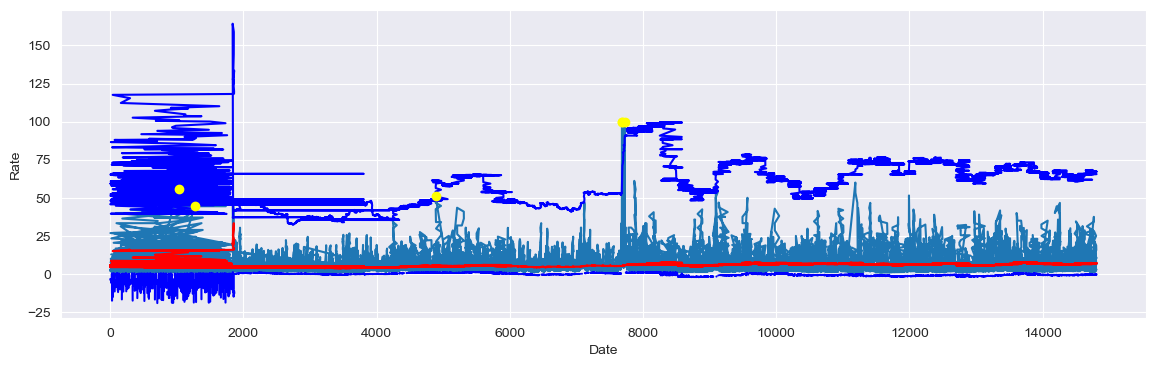

In [939]:
def outlier_detection_kurtosis(j, std_param=3, window_length=720):
    rmeans = j.rolling(window_length, min_periods=1).median()
    rstd = j.rolling(window_length, min_periods=1).std()
    rstd_lower = j[j.values < rmeans.values].rolling(window_length, min_periods=1).std()

    kurtosis_value = j.kurt()

    upper = rmeans + std_param * rstd * np.exp(0.08 * kurtosis_value)
    lower = rmeans - (4.95 * rstd_lower)
    idx1 = (j.values > upper.values)
    idx2 = (j.values < lower.values)

    idx = idx1 | idx2

    return j, idx, rmeans, upper, lower

j, idx, rmeans, upper, lower = outlier_detection_kurtosis(df_street['Violation_Rate'])
plot_outlier_detection(j, idx, rmeans, upper, lower)
j[idx] = np.nan

In [940]:
df_street['Violation_Rate'].isnull().sum()

6

In [941]:
df_street = df_street.interpolate(method='linear', limit_direction='both')

In [942]:
df_street['Violation_Rate'].isnull().sum()

0

In [943]:
# X = df_1[['Violation Datetime']]
# y = df_1['Violation Rate (Scaled)']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [944]:
df_street = df_street.set_index('Violation Datetime')

In [945]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,41.666667
2016-06-30 08:55:00,33.333333
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,7.843137
2023-09-28 03:13:00,5.882353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


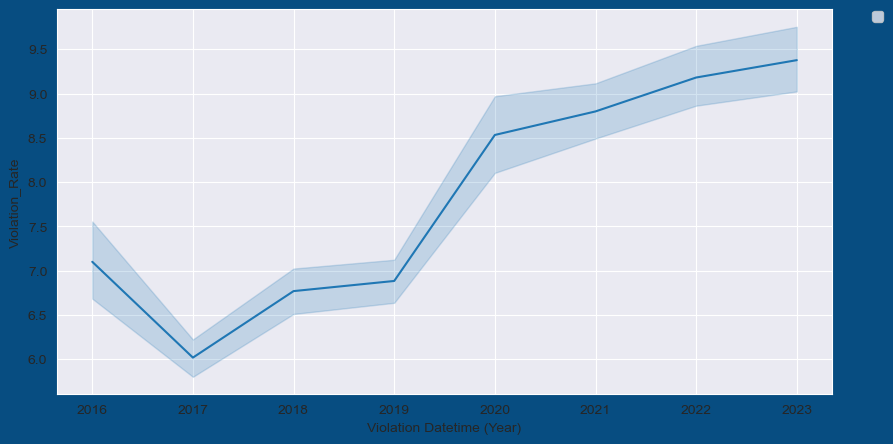

In [946]:
plt.figure(figsize=(10,5),facecolor="#074d81")
ax=sns.lineplot(x="Violation Datetime (Year)", y="Violation_Rate", data=df_1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

Text(0.5, 0, 'Date')

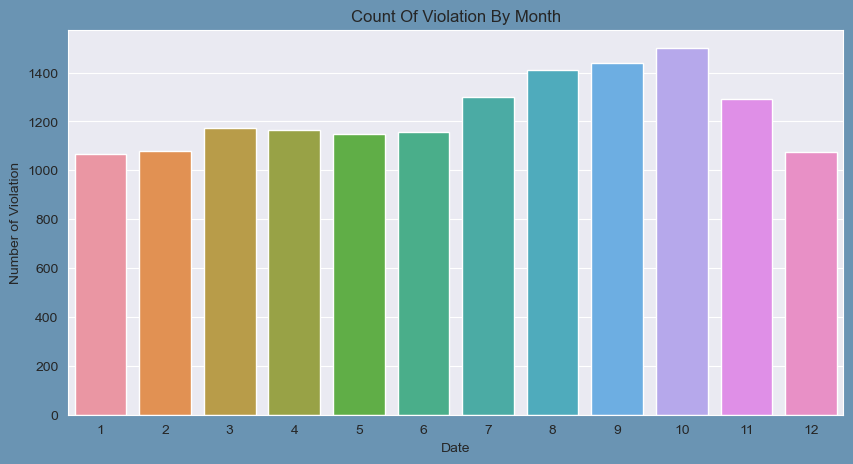

In [947]:
plt.figure(figsize=(10,5),facecolor="#6a94b3")
count = sns.countplot(data=df, x=df_1["Violation Datetime (Month)"])
count.set_title("Count Of Violation By Month")
count.set_ylabel("Number of Violation")
count.set_xlabel("Date")

In [948]:
df_street.describe()

,Violation_Rate
count,14803.000000
mean,7.813181
std,6.985820
min,0.813008
25%,2.941176
50%,5.454545
75%,10.256410
max,69.230769


In [949]:
df_street.head()

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,41.666667
2016-06-30 08:55:00,33.333333


In [950]:
def plots(df_, start_date=None, end_date=None, title=None):

    if start_date is not None and end_date is not None:
        df_ = df_street[(df_street.index >= start_date) & (df_street.index <= end_date)]

    plt.figure(figsize=(15, 8))
    # plt.plot(df_.index, df_['Violation Rate (Scaled)'], label='Violation Rate')
    plot = sns.lineplot(data=df_)
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.title(title)

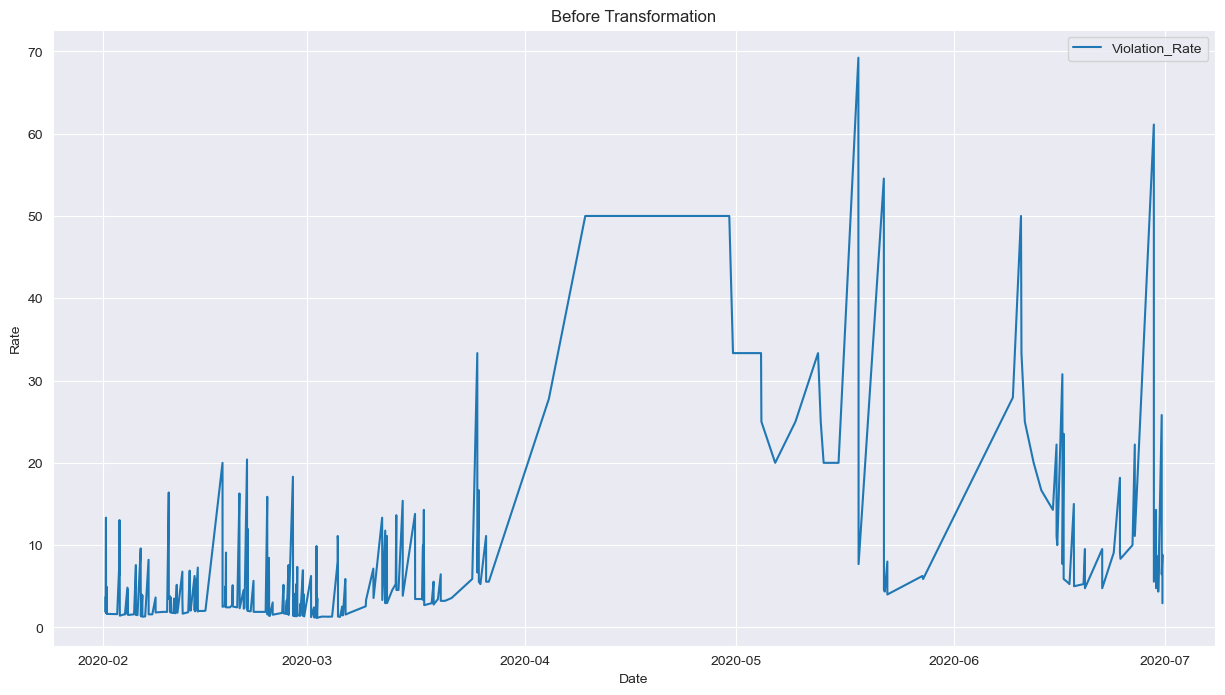

In [951]:
plots(df_street, start_date='2020-02-01 00:00:00', end_date='2020-07-01 00:00:00', title='Before Transformation')

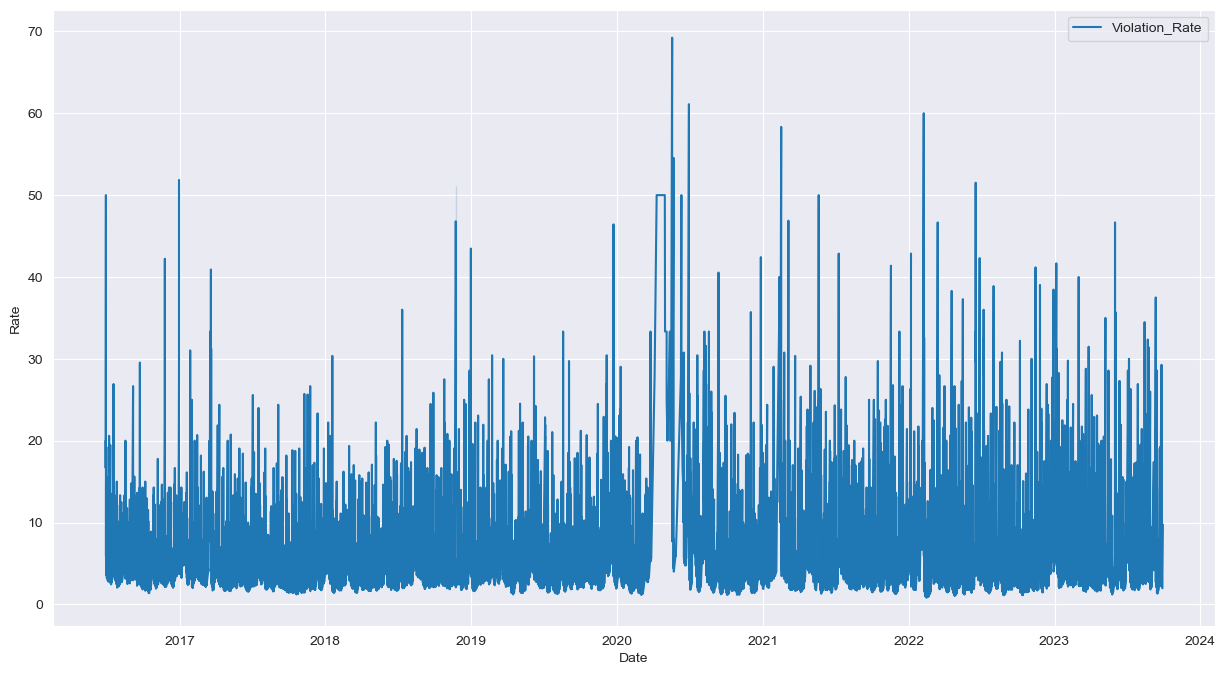

In [952]:
plots(df_street)

In [953]:
df_street['Violation_Rate']

Violation Datetime
2016-06-29 16:23:00    20.000000
2016-06-29 20:40:00    16.666667
2016-06-30 08:52:00    50.000000
2016-06-30 08:53:00    41.666667
2016-06-30 08:55:00    33.333333
                         ...    
2023-09-28 03:09:00     9.803922
2023-09-28 03:11:00     7.843137
2023-09-28 03:13:00     5.882353
2023-09-28 03:15:00     3.921569
2023-09-28 03:17:00     1.960784
Name: Violation_Rate, Length: 14803, dtype: float64

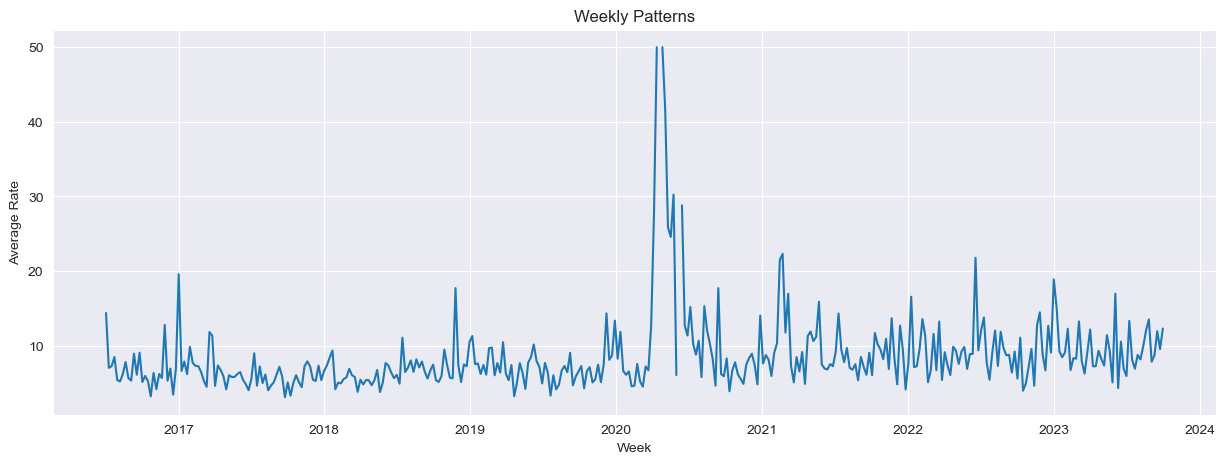

In [954]:
weekly_data = df_street.resample('W').mean()  # Weekly average
plt.figure(figsize=(15, 5))
plt.plot(weekly_data['Violation_Rate'])
plt.title('Weekly Patterns')
plt.xlabel('Week')
plt.ylabel('Average Rate')
plt.show()

In [955]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,41.666667
2016-06-30 08:55:00,33.333333
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,7.843137
2023-09-28 03:13:00,5.882353


Steps for Transforming: Normalizing - Differencing

In [956]:
# Normalize Function
def normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [957]:
df_normalized_street, av_J1, std_J1 = normalize(df_street, "Violation_Rate")
diff_street = difference(df_normalized_street, col="Violation_Rate", interval=1) #taking a day's difference
df_normalized_street = df_normalized_street[1:]
df_street = df_street[1:]
df_normalized_street.columns = ["Norm"]
df_normalized_street["Diff"]= diff_street
df_normalized_street.head()

,Norm,Diff
Violation Datetime,,
2016-06-29 20:40:00,1.267351,-0.477157
2016-06-30 08:52:00,6.038922,4.771571
2016-06-30 08:53:00,4.846029,-1.192893
2016-06-30 08:55:00,3.653137,-1.192893
2016-06-30 08:56:00,2.460244,-1.192893


In [958]:
df_normalized_street

,Norm,Diff
Violation Datetime,,
2016-06-29 20:40:00,1.267351,-0.477157
2016-06-30 08:52:00,6.038922,4.771571
2016-06-30 08:53:00,4.846029,-1.192893
2016-06-30 08:55:00,3.653137,-1.192893
2016-06-30 08:56:00,2.460244,-1.192893
...,...,...
2023-09-28 03:09:00,0.284969,1.092214
2023-09-28 03:11:00,0.004288,-0.280681
2023-09-28 03:13:00,-0.276392,-0.280681


In [959]:
df_normalized_street, df_street

(                         Norm      Diff
 Violation Datetime                     
 2016-06-29 20:40:00  1.267351 -0.477157
 2016-06-30 08:52:00  6.038922  4.771571
 2016-06-30 08:53:00  4.846029 -1.192893
 2016-06-30 08:55:00  3.653137 -1.192893
 2016-06-30 08:56:00  2.460244 -1.192893
 ...                       ...       ...
 2023-09-28 03:09:00  0.284969  1.092214
 2023-09-28 03:11:00  0.004288 -0.280681
 2023-09-28 03:13:00 -0.276392 -0.280681
 2023-09-28 03:15:00 -0.557073 -0.280681
 2023-09-28 03:17:00 -0.837754 -0.280681
 
 [14802 rows x 2 columns],
                      Violation_Rate
 Violation Datetime                 
 2016-06-29 20:40:00       16.666667
 2016-06-30 08:52:00       50.000000
 2016-06-30 08:53:00       41.666667
 2016-06-30 08:55:00       33.333333
 2016-06-30 08:56:00       25.000000
 ...                             ...
 2023-09-28 03:09:00        9.803922
 2023-09-28 03:11:00        7.843137
 2023-09-28 03:13:00        5.882353
 2023-09-28 03:15:00        3.9

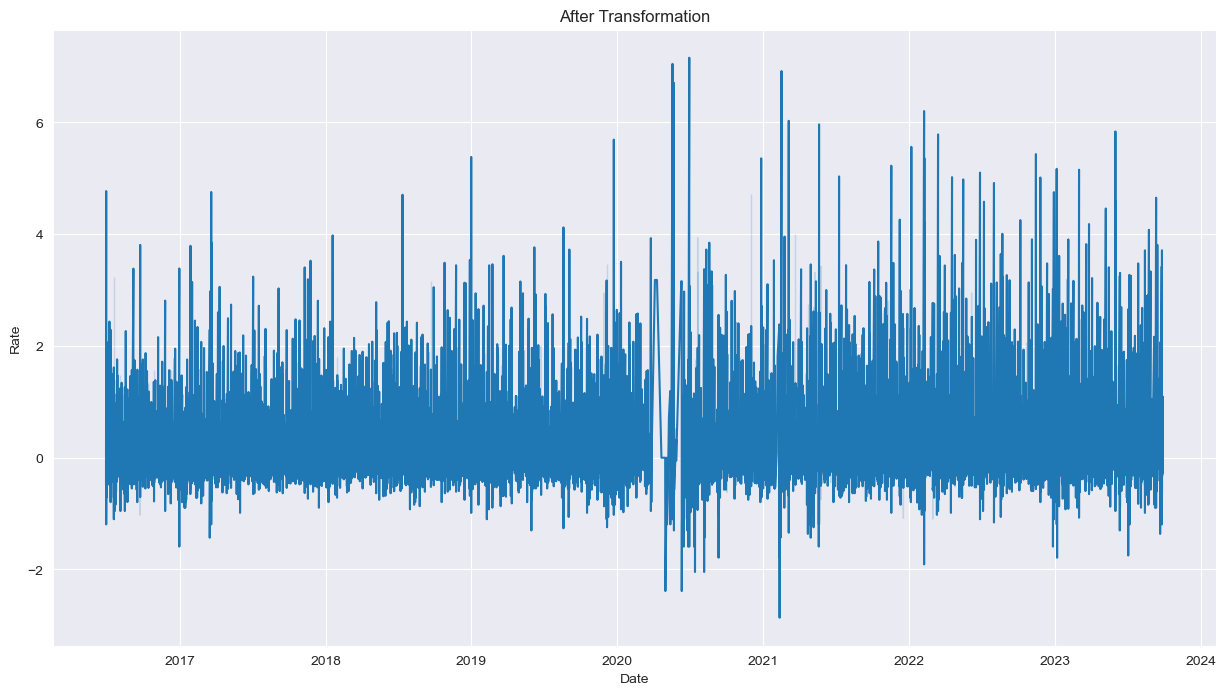

In [960]:
plots(df_normalized_street.Diff, title='After Transformation')

In [961]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df_all_junctions):
    check = adfuller(df_all_junctions.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")

#Checking if the series is stationary
check_stationary(df_normalized_street.Diff)

ADF Statistic: -29.743495202329267
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [962]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,41.666667
2016-06-30 08:55:00,33.333333
2016-06-30 08:56:00,25.000000
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,7.843137
2023-09-28 03:13:00,5.882353


In [963]:
df_street_not_normalized = df_street.copy()
df_street = df_normalized_street["Diff"].dropna()  #dropping null values
df_street = df_street.to_frame()

In [964]:
df_street

,Diff
Violation Datetime,
2016-06-29 20:40:00,-0.477157
2016-06-30 08:52:00,4.771571
2016-06-30 08:53:00,-1.192893
2016-06-30 08:55:00,-1.192893
2016-06-30 08:56:00,-1.192893
...,...
2023-09-28 03:09:00,1.092214
2023-09-28 03:11:00,-0.280681
2023-09-28 03:13:00,-0.280681


In [965]:
#Splitting the dataset
def split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

#Splitting the training and test datasets
df_street_train, df_street_test = split_data(df_street)

In [966]:
#Target and Feature - We are using the previous 'steps' time periods to predict the next time period.
def target_and_feature(df):
    end_len = len(df)
    X = []
    y = []
    steps = 24
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

In [967]:
#fixing the shape of X_test and X_train
def feature_fix_shape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [968]:
df_street_train

array([[-0.47715709],
       [ 4.77157089],
       [-1.19289272],
       ...,
       [-0.21688959],
       [-0.21688959],
       [-0.00971147]])

In [969]:
# Assigning features and target
X_train_street, y_train_street = target_and_feature(df_street_train)
X_test_street, y_test_street = target_and_feature(df_street_test)
X_train_street, X_test_street = feature_fix_shape(X_train_street, X_test_street)

In [970]:
X_train_street.shape

(11817, 24, 1)

In [971]:
y_train_street.shape

(11817,)

In [972]:
def lstm_model(X_train, y_train, X_test, y_test): # Model for the prediction
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) # early stopping to prevent overfitting

    # The LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Learning rate and momentum settings
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping], shuffle=False)
    pred_lmts = model.predict(X_test)
    return pred_lmts



def rmse_value(test, predicted): # To calculate the root mean squared error in predictions
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


def predictions_plot(test, predicted, m): # To plot the comparative plot of targets and predictions
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    plt.plot(test, label="True Value", alpha=0.5)
    plt.plot(predicted, color="#627D78", label="Predicted Values")
    plt.title("LSTM Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()

In [973]:
pred_street = lstm_model(X_train_street,y_train_street,X_test_street, y_test_street) # #Predictions

Epoch 1/50
99/99 [==============================] - 27s 178ms/step - loss: 0.4568 - val_loss: 0.5975
Epoch 2/50
99/99 [==============================] - 15s 156ms/step - loss: 0.4570 - val_loss: 0.5974
Epoch 3/50
99/99 [==============================] - 15s 154ms/step - loss: 0.4569 - val_loss: 0.5974
Epoch 4/50
99/99 [==============================] - 15s 156ms/step - loss: 0.4572 - val_loss: 0.5974
Epoch 5/50
99/99 [==============================] - 15s 154ms/step - loss: 0.4573 - val_loss: 0.5974
Epoch 6/50
99/99 [==============================] - 15s 155ms/step - loss: 0.4568 - val_loss: 0.5975
Epoch 7/50
99/99 [==============================] - 16s 159ms/step - loss: 0.4573 - val_loss: 0.5974
Epoch 8/50
99/99 [==============================] - 15s 156ms/step - loss: 0.4573 - val_loss: 0.5973
Epoch 9/50
99/99 [==============================] - 15s 155ms/step - loss: 0.4570 - val_loss: 0.5973
Epoch 10/50
99/99 [==============================] - 15s 154ms/step - loss: 0.4569 - val_lo

In [974]:
y_test_street.shape

(2937,)

In [975]:
pred_street.shape

(2937, 1)

The root mean squared error is 0.7729490420181868.


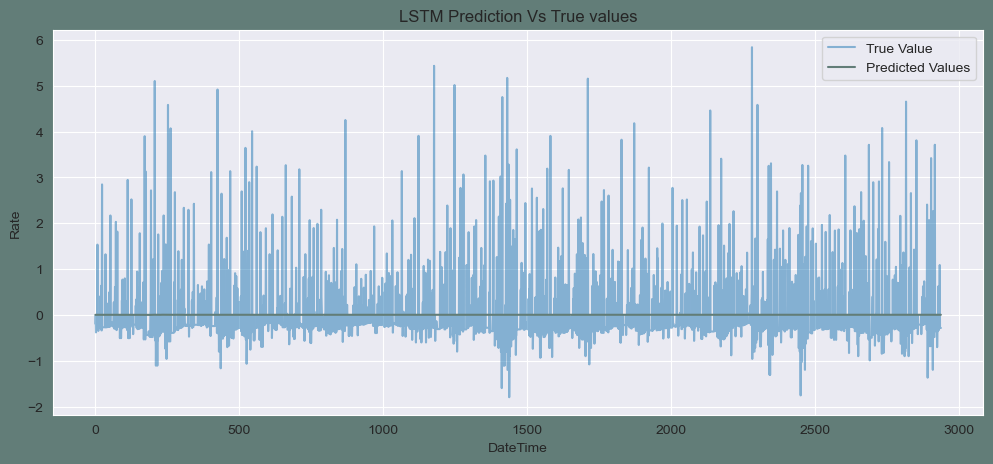

In [976]:
rmse = rmse_value(y_test_street, pred_street) # Results
predictions_plot(y_test_street, pred_street, 0)

In [977]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1)
    axes[0].set(ylabel ="Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2["Violation_Rate"], color="#627D78")
    axes[1].set(ylabel ="Original")

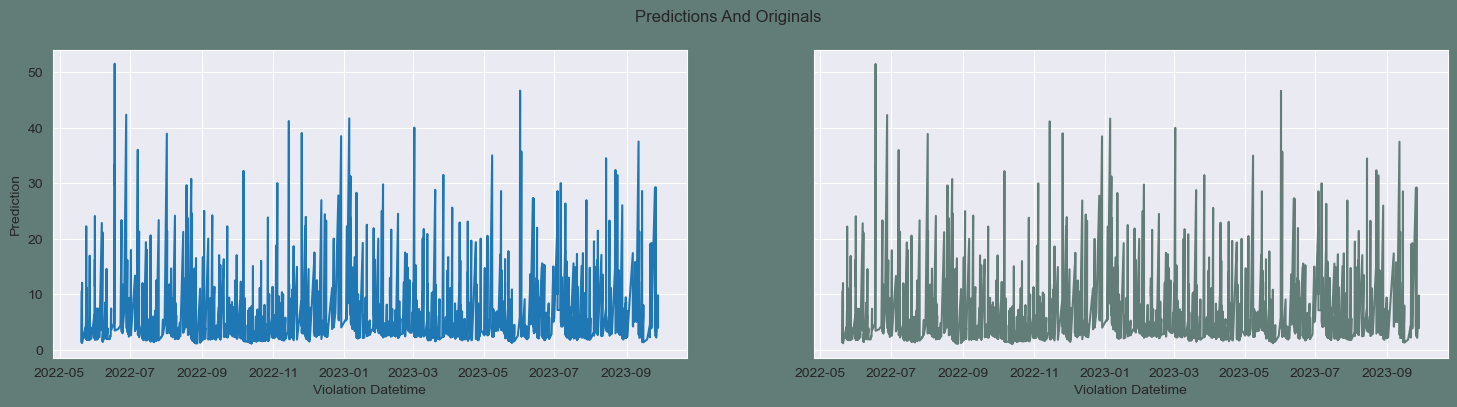

In [983]:
# invert the differenced forecas
recover_1 = df_normalized_street.Norm[-2938:-1].to_frame()
recover_1["Pred"]= pred_street
transform_reversed = inverse_difference(recover_1.Norm, recover_1.Pred).to_frame()
transform_reversed.columns = ["Pred_Normed"]
#Invert the normalization
final_pred = (transform_reversed.values* std_J1) + av_J1
transform_reversed["Pred_Final"] = final_pred
#Plotting the Predictions with originals
sub_plots_2(transform_reversed["Pred_Final"], df_street_not_normalized[-2938:-1],"Predictions And Originals", 0)

In [984]:
combined_df = pd.concat([transform_reversed["Pred_Final"], df_street_not_normalized[-2938:-1]], axis=1)
combined_df.columns = ["Pred", "Original"]
combined_df

,Pred,Original
Violation Datetime,,
2022-05-20 00:08:00,10.572812,10.526316
2022-05-20 00:09:00,9.256824,9.210526
2022-05-20 00:09:00,9.256581,9.210526
2022-05-20 00:10:00,6.624393,6.578947
2022-05-20 00:12:00,5.308016,5.263158
...,...,...
2023-09-26 15:28:00,2.221614,2.173913
2023-09-28 03:09:00,9.850572,9.803922
2023-09-28 03:11:00,7.894510,7.843137
